In [39]:
from fbprophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error, r2_score

In [40]:
link = 'https://docs.google.com/spreadsheets/d/1mf-u-MkniXMhCzbtOQOuXhS2BVkOuygf/export'

In [41]:
df = pd.read_excel(link)
df

,Month,Thousands of Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0
...,...,...
139,1960-08-01,606.0
140,1960-09-01,508.0
141,1960-10-01,461.0
142,1960-11-01,390.0


In [42]:
df['Month'] = pd.to_datetime(df['Month'].dt.strftime('%Y-%m-%d'))

In [43]:
df['Thousands of Passengers'] = (df['Thousands of Passengers']).astype(int)

In [44]:
df.head()

,Month,Thousands of Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [45]:
df.tail()

,Month,Thousands of Passengers
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


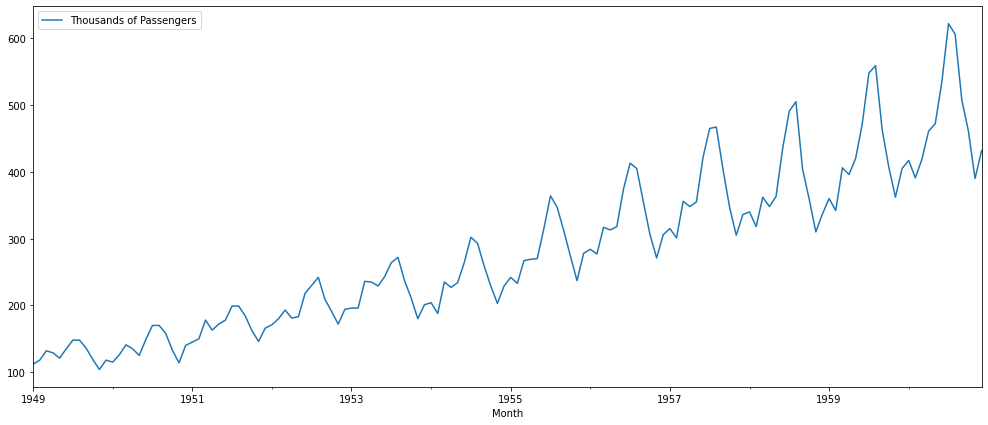

In [46]:
df.plot('Month', 'Thousands of Passengers', figsize=(17,7))

In [47]:
df = df.rename(columns={'Month':'ds','Thousands of Passengers':'y'})
df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [48]:
df['ds'].quantile(0.80)

Timestamp('1958-07-13 09:36:00')

In [49]:
cut = pd.to_datetime('1958-07-01')
train = df[df['ds'] < cut]
test = df[df['ds'] >= cut]

In [50]:
train.tail()

,ds,y
109,1958-02-01,318
110,1958-03-01,362
111,1958-04-01,348
112,1958-05-01,363
113,1958-06-01,435


In [51]:
test.head()

,ds,y
114,1958-07-01,491
115,1958-08-01,505
116,1958-09-01,404
117,1958-10-01,359
118,1958-11-01,310


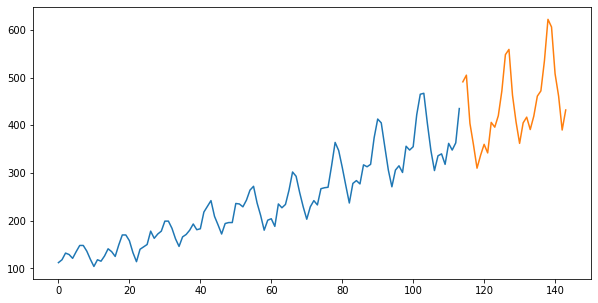

In [52]:
fig,ax = plt.subplots(figsize=(10,5))
train['y'].plot(ax=ax);
test['y'].plot(ax=ax);

In [53]:
model = Prophet()
model.add_seasonality(name='yearly', period=365*3, fourier_order=10)
model.fit(train)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [54]:
future = model.make_future_dataframe(periods=365*4, freq='D')
forecast = model.predict(future)

In [55]:
plot_plotly(model, forecast)

In [56]:
plot_components_plotly(model, forecast)

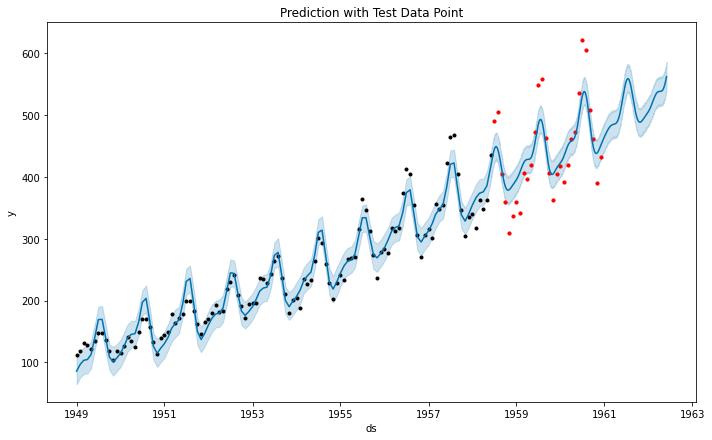

In [57]:
fig = model.plot(forecast)
plt.scatter(x=test['ds'], y=test['y'], s=10, color='red')
plt.grid(False)
plt.title('Prediction with Test Data Point')
plt.show()

In [58]:
pred = model.predict(test)

In [59]:
r2_score(test['y'],pred['yhat'])

0.698815689342815

In [60]:
np.sqrt(mean_squared_error(test['y'],pred['yhat']))

42.45264041388314

In [61]:
from fbprophet.diagnostics import cross_validation

cv = cross_validation(model,initial='1095 days', horizon='365 days')
cv

INFO:fbprophet:Making 11 forecasts with cutoffs between 1952-06-02 00:00:00 and 1957-06-01 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1952-07-01,217.952767,210.767537,224.347221,230,1952-06-02
1,1952-08-01,213.848173,207.312914,220.915004,242,1952-06-02
2,1952-09-01,195.784756,189.040362,202.391499,209,1952-06-02
3,1952-10-01,181.681073,175.067629,188.360259,191,1952-06-02
4,1952-11-01,175.373496,168.526796,181.916856,172,1952-06-02
...,...,...,...,...,...,...
126,1958-02-01,386.653743,368.556285,405.427019,318,1957-06-01
127,1958-03-01,393.666675,375.263086,411.345599,362,1957-06-01
128,1958-04-01,394.322125,376.092803,412.677530,348,1957-06-01
129,1958-05-01,400.312174,381.736933,417.353349,363,1957-06-01


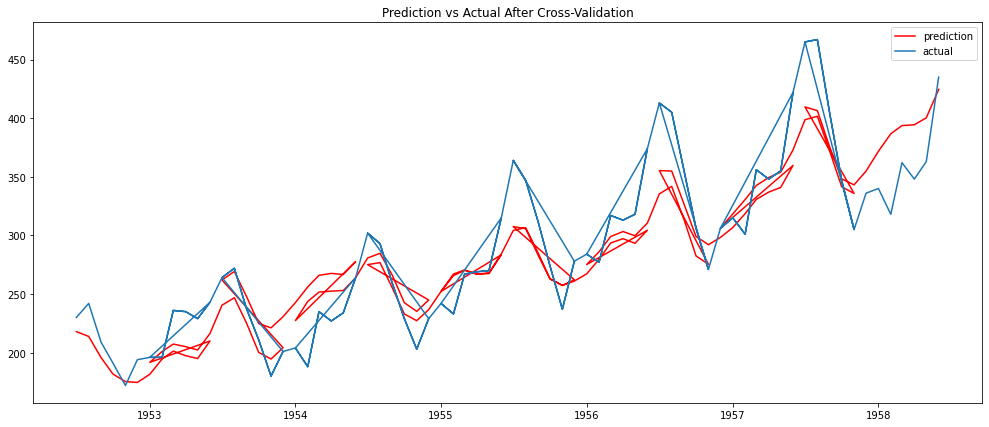

In [62]:
plt.figure(figsize=(17,7))
plt.plot(cv['ds'],cv['yhat'],c='red',label='prediction')
plt.plot(cv['ds'],cv['y'],label='actual')
plt.legend()
plt.title('Prediction vs Actual After Cross-Validation')
plt.show()

In [63]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv)
df_p.tail(10)

,horizon,mse,rmse,mae,mape,mdape,coverage
33,303 days 12:00:00,664.779333,25.783315,22.234721,0.077944,0.071050,0.230769
34,304 days 00:00:00,722.559009,26.880458,22.565222,0.078388,0.059506,0.282051
35,304 days 12:00:00,720.422441,26.840686,22.444170,0.077112,0.059506,0.307692
36,333 days 00:00:00,599.692724,24.488624,20.024063,0.075940,0.050997,0.358974
37,334 days 00:00:00,601.134793,24.518050,20.859638,0.071257,0.059506,0.358974
38,334 days 12:00:00,642.924893,25.355964,22.333369,0.083051,0.081010,0.282051
39,335 days 12:00:00,588.187173,24.252570,21.284097,0.081010,0.081010,0.307692
40,364 days 00:00:00,661.231406,25.714420,23.297937,0.088401,0.085713,0.205128
41,364 days 12:00:00,530.064710,23.023134,20.487272,0.078460,0.081010,0.205128
42,365 days 00:00:00,1054.287661,32.469796,25.814660,0.086345,0.085713,0.230769
